# A bias mitigation application of model differencing

In this notebook we demonstrate the use of the Interpretable Model Differencing explainer to make an assessment of how a bias mitigation intervention performs. We use the Ad-campaign dataset described [here](https://github.com/Trusted-AI/AIF360/blob/master/examples/tutorial_bias_advertising.ipynb). 

We first gather relevant resources to this. Install [AIF360](https://github.com/Trusted-AI/AIF360), the AI Fairness 360 toolkit and get the data described [here](https://developer.ibm.com/exchanges/data/all/bias-in-advertising/).

## Setup

In [4]:
DATAFILE = "bias.tar.gz"

In [ ]:
%pip install aif360

In [5]:
!curl https://dax-cdn.cdn.appdomain.cloud/dax-bias-in-advertising/1.0.0/bias-in-advertising.tar.gz -o $DATAFILE


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 17.3M  100 17.3M    0     0  22.9M      0 --:--:-- --:--:-- --:--:-- 23.0M


In [8]:
!tar -xvf $DATAFILE

x bias-in-advertising/
x bias-in-advertising/ad_campaign_data.csv
x bias-in-advertising/README.txt
x bias-in-advertising/LICENSE.txt


## Bias mitigation

We recreate a bias mitigated model described in the [tutorial](https://github.com/Trusted-AI/AIF360/blob/master/examples/tutorial_bias_advertising.ipynb) using a post-processing bias mitigation technique called [Reject Option Classifier](https://aif360.readthedocs.io/en/stable/modules/generated/aif360.sklearn.postprocessing.RejectOptionClassifier.html). More details on the process are available on the tutorial notebook and skipped here. What we are interested in is the final bias mitigated output.

In [9]:
from time import time

import pandas as pd
import numpy as np
from pprint import pprint

from aif360.datasets import StandardDataset
from aif360.metrics import ClassificationMetric, BinaryLabelDatasetMetric
from aif360.algorithms.postprocessing import RejectOptionClassification

from aif360.detectors.mdss.ScoringFunctions import Bernoulli
from aif360.detectors.mdss.MDSS import MDSS
from aif360.detectors.mdss.generator import get_random_subset

# %%
df = pd.read_csv("bias-in-advertising/ad_campaign_data.csv", low_memory=False)
df.head()

,religion,politics,college_educated,parents,homeowner,gender,age,income,area,true_conversion,predicted_conversion,predicted_probability
0,Unknown,Unknown,1,1,1,Unknown,55-64,Unknown,Unknown,0,0,0.001351
1,Other,Unknown,1,1,1,Unknown,55-64,Unknown,Urban,0,0,0.002238
2,Unknown,Unknown,1,1,1,F,55-64,Unknown,Unknown,0,0,0.002704
3,Unknown,Unknown,1,1,1,F,55-64,Unknown,Unknown,0,0,0.001967
4,Unknown,Unknown,1,1,1,F,55-64,Unknown,Urban,0,0,0.001681


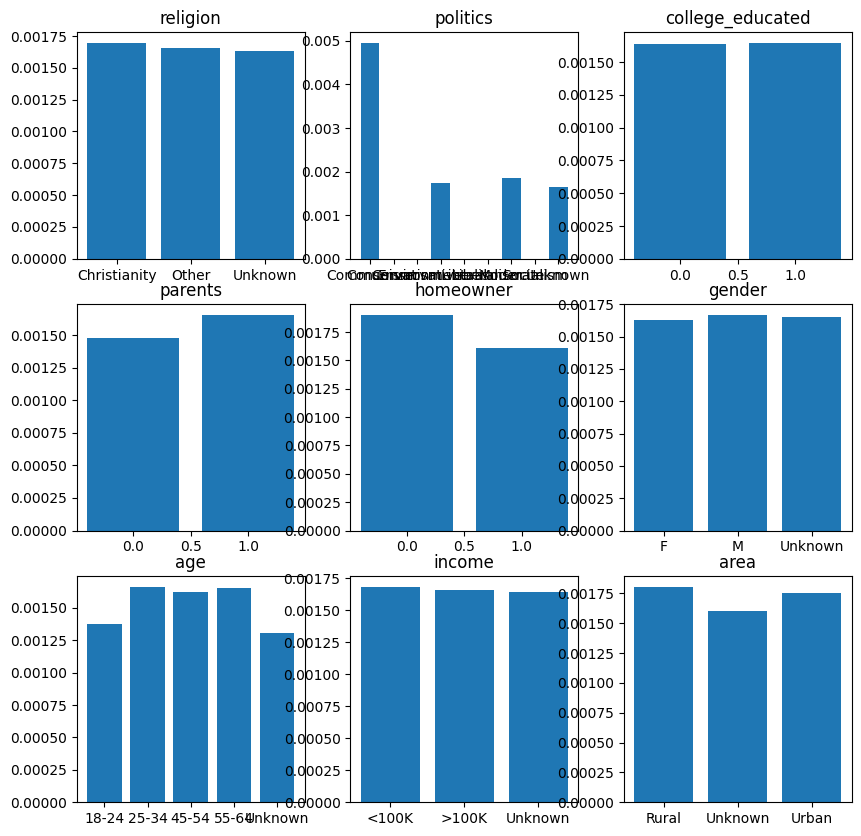

In [10]:

FEATURES = ['religion', 'politics', 'college_educated', 
        'parents', 'homeowner', 'gender', 'age', 'income', 'area']
TARGET = "true_conversion"
categorical_cols = FEATURES
numeric_cols = []


# %% See conversion rates by feature
import matplotlib.pyplot as plt

def featurewise_conversion(df, f) -> pd.DataFrame:
    outdf = df.groupby(by=f).apply(lambda x: sum(x['true_conversion'])/len(x)).to_frame().reset_index()
    outdf.rename(columns={f: 'attribute', 0:'val'}, inplace=True)
    outdf['feature'] = f
    return outdf

pltdf = pd.concat([featurewise_conversion(df, f) for f in FEATURES], axis=0)

fig, axarr = plt.subplots(3, 3, figsize=(10, 10))
for ax, f in zip(axarr.flatten(), FEATURES):
    ax.bar(data=pltdf[pltdf.feature==f], x="attribute", height='val')
    #sns.pointplot(ax=ax, data=pltdf[pltdf.feature==f], y="val", x='attribute')
    ax.set_title(f)

In [11]:
# Some utilities to report click through rates for arbitrary cohorts

def print_report(data, subset):
    """ Report on subsets """
    if subset:
        to_choose = data[subset.keys()].isin(subset).all(axis = 1)
        df = data[['true_conversion', 'predicted_conversion']][to_choose]
    else:
        df = data[['true_conversion', 'predicted_conversion']]

    true = df['true_conversion'].sum()
    pred = df['predicted_conversion'].sum()
    
    print('\033[1mSubset: \033[0m')
    pprint(subset)
    print('\033[1mSubset Size: \033[0m', len(df))
    print('\033[1mTrue Clicks: \033[0m', true)
    print('\033[1mPredicted Clicks: \033[0m', pred)
    print()

np.random.seed(42)
random_subset = get_random_subset(df[FEATURES], prob = 0.05, min_elements = 10000)
print_report(df, random_subset)

Subset: 
{'homeowner': [0]}
Subset Size:  174654
True Clicks:  332
Predicted Clicks:  1944



## For which cohorts are the predictions worst? 

Using the MDSS scan algorithm, we examine the data to determine a cohort for which the classifier is poorly calibrated.

In [12]:
# %% For which cohort are the predictions worst?

from time import time

# Bias scan
scoring_function = Bernoulli(direction='negative')
scanner = MDSS(scoring_function)

start_time = time()
scanned_subset, _ = scanner.scan(df[FEATURES], 
                        expectations = df['predicted_conversion'],
                        outcomes = df['true_conversion'], 
                        penalty = 1, 
                        num_iters = 1,
                        verbose = False)


print('Scan done in {:3.2f} sec.'.format(time() - start_time))
print_report(df, scanned_subset)

# %%
print_report(df, {'homeowner':[0]})

print_report(df, {'homeowner':[1]})



Scan done in 12.45 sec.
Subset: 
{'area': ['Unknown', 'Urban'], 'homeowner': [0], 'income': ['>100K', 'Unknown']}
Subset Size:  153883
True Clicks:  281
Predicted Clicks:  1907

Subset: 
{'homeowner': [0]}
Subset Size:  174654
True Clicks:  332
Predicted Clicks:  1944

Subset: 
{'homeowner': [1]}
Subset Size:  1268486
True Clicks:  2042
Predicted Clicks:  423



This suggests that the model is overly conservative for homeowners (423 clicks predicted vs. 2042 actuals) and optimistic for non-homeowheres (1944 predicted clicks vs. 332 actual). This suggests a bias towards homeowners. We now look to remedy this using ROC.

In [13]:
def convert_to_standard_dataset(df, target_label_name, scores_name=""):

    # List of names corresponding to protected attribute columns in the dataset.
    # Note that the terminology "protected attribute" used in AI Fairness 360 to
    # divide the dataset into multiple groups for measuring and mitigating 
    # group-level bias.
    protected_attributes=['homeowner']
    
    # columns from the dataset that we want to select for this Bias study
    selected_features = ['gender', 'age', 'income', 'area', 'college_educated', 'homeowner', 
                         'parents', 'predicted_probability']
    
    # This privileged class is selected based on MDSS subgroup evaluation.
    # in previous steps. In our case non-homeowner (homeowner=0) are considered to 
    # be privileged and homeowners (homeowner=1) are considered as unprivileged.
    privileged_classes = [[0]]   

    # Label values which are considered favorable are listed. All others are 
    # unfavorable. Label values are mapped to 1 (favorable) and 0 (unfavorable) 
    # if they are not already binary and numerical.
    favorable_target_label = [1]

    # List of column names in the DataFrame which are to be expanded into one-hot vectors.
    categorical_features = ['parents','gender','college_educated','area','income', 'age']

    # create the `StandardDataset` object
    standard_dataset = StandardDataset(df=df, label_name=target_label_name,
                                    favorable_classes=favorable_target_label,
                                    scores_name=scores_name,
                                    protected_attribute_names=protected_attributes,
                                    privileged_classes=privileged_classes,
                                    categorical_features=categorical_features,
                                    features_to_keep=selected_features)
    if scores_name=="":
        standard_dataset.scores = standard_dataset.labels.copy()
        
    return standard_dataset


# Create two StandardDataset objects - one with true conversions and one with
# predicted conversions.

# First create the predicted dataset
xdf_pred = convert_to_standard_dataset(df, 
                                            target_label_name = 'predicted_conversion',
                                            scores_name='predicted_probability')

# Use this to create the original dataset
xdf_true = xdf_pred.copy()
xdf_true.labels = df["true_conversion"].values.reshape(-1, 1)
xdf_true.scores = df["true_conversion"].values.reshape(-1, 1)

# %% Compute disparate impact ratio
#When this ratio is observed to be less than 1, the first (unprivileged) group is considered disadvantaged compared to the second group. Similarly, if this ratio is much larger than 1, the first (privileged) group is considered to be at a relative advantage. Depending on the scenario, this ratio can vary widely, say from a value close to 0 to a value much larger than 1. These numbers represent the data or algorithms’ bias towards or against specific groups within an audience and could be due to bias in the training data or some inherent unintended bias in the way the algorithms are designed and optimized.

privileged_groups= [{'homeowner': 0}] # does not own a home, subclause determined by the bias scan
unprivileged_groups = [{'homeowner': 1}]

metric_orig = BinaryLabelDatasetMetric(xdf_true, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print(f"Disparate impact for the original dataset = {metric_orig.disparate_impact():.4f}")

metric_pred = BinaryLabelDatasetMetric(xdf_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print(f"Disparate impact for the predicted dataset = {metric_pred.disparate_impact():.4f}")

# Conclusion is that the model introduces disparate impact (since the ratio is so low for predictions

# %% Bias mitigation via Reject Option Classification
# 
# # Metric used (should be one of allowed_metrics)
metric_name = "Statistical parity difference"

# Upper and lower bound on the fairness metric used
metric_ub = 0.05
metric_lb = -0.05
        
#random seed for calibrated equal odds prediction
np.random.seed(1)

# Verify metric name
allowed_metrics = ["Statistical parity difference",
                   "Average odds difference",
                   "Equal opportunity difference"]


# Fit the method
start_time = time()

ROC = RejectOptionClassification(unprivileged_groups=unprivileged_groups,
                                 privileged_groups=privileged_groups,
                                            low_class_thresh=0.01, high_class_thresh=0.99,
                                            num_class_thresh=100, num_ROC_margin=50,
                                            metric_name=metric_name,
                                            metric_ub=metric_ub, metric_lb=metric_lb)
xdf_roc = ROC.fit_predict(xdf_true, xdf_pred)
print('ROC fit done in {:3.2f} sec.'.format(time() - start_time))

# %%
print("Optimal classification threshold (with fairness constraints) = %.4f" % ROC.classification_threshold)
print("Optimal ROC margin = %.4f" % ROC.ROC_margin)


# %% Now we need a set of 
df['roc_conversion'] = xdf_roc.labels.astype(int)

Disparate impact for the original dataset = 0.8469
Disparate impact for the predicted dataset = 0.0300
ROC fit done in 1362.46 sec.
Optimal classification threshold (with fairness constraints) = 0.0100
Optimal ROC margin = 0.0051


In [14]:
# Persist training data and the two labels
df.to_pickle("bia.pkl")

## Interpretable model differencing

We now have two models - a base model and a bias mitigated model. We'd like to investigate if the mitigation worked as intended or had any unintended effects. 

In [21]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np

# Contains the training data and the two labels
df = pd.read_pickle("bia.pkl")

FEATURES = ['religion', 'politics', 'college_educated', 
            'parents', 'homeowner',
            'gender', 'age', 'income', 'area']

c1 = 'predicted_conversion' # The is the base model
c2 = 'roc_conversion'       # This is the bias mitigated version

tmp = df
x = tmp[FEATURES]
y1 = tmp[c1].values
y2 = tmp[c2].values

# Transform to numeric data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), []),
        ('cat', OneHotEncoder(handle_unknown='ignore'), FEATURES)])

t = preprocessor.fit_transform(x)
if isinstance(t, np.ndarray):
    x_t_s = t
else:
    x_t_s = preprocessor.fit_transform(x).toarray()

gf=preprocessor.get_feature_names_out()
v_gf = [i.split("_")[2] for i in gf]
c_gf = [i.split("_")[-1] for i in gf]
#namemap = {f"x{i}": v for i,v in enumerate(FEATURES)}
features = [f"{a}={b}" for a, b in zip(v_gf, c_gf)]

x_t = pd.DataFrame(x_t_s, columns=features)

In [31]:
from aix360.algorithms.imd.imd import IMDExplainer

from time import time
start_time = time()

sym = IMDExplainer()
t1, t2 = sym.fit(x_t, y1, y2, max_depth=6) 

print('Difference model learnt in {:3.2f} sec.'.format(time() - start_time))


diffs in X_train = 303441 / 1443140 = 21.03%


TypeError: cannot unpack non-iterable NoneType object

In [ ]:

diffrules = sym.diffrules(ct)
print(f"len diffrules = {len(diffrules)}")
print(diffrules)


# %%
import pickle
with open("test.g", 'wb') as outfile:
    pickle.dump(ct, outfile)
# %% 

import pickle
with open("test.g", 'rb') as infile:
    ct = pickle.load(infile)

import src.algos.common_tree_utils as ctu
from IPython.display import Image

T = ctu.common_trunk_tree_to_digraph(ct)
ctu.graph_to_image(T, "tmp.png")

# %% Highlight only differences in JST
from networkx.drawing.nx_agraph import to_agraph
A =to_agraph(T)
A.layout('dot', args="-Gnodesep=0.05")
A.draw("full.png")
# %%
import networkx as nx
def selector(G:nx.DiGraph):
    """ Attaches an attribute on which nodes to hide """

    def is_leaf(G, n): return len(list(G.successors(n))) == 0
    def _recurser(n):
        labels = []
        if 'label' in G.nodes[n]:
            # either split/leaf node
            if 'pred' in G.nodes[n]:
                labels.append(G.nodes[n]['pred'])
            else:
                for i in G.neighbors(n):
                    labels += _recurser(i)

        else:
            # diverging node
            for i in G.neighbors(n):
                labels += _recurser(i)
        
        # add an attribute to this node if labels are homogenous
        G.nodes[n]['hide'] = True if len(set(labels)) == 1 else False
        print(f"Node:{n} labels:{labels} status: {G.nodes[n]['hide']}")

        return labels

    _recurser(0)
    return G

G = selector(T)

# %%
print(f"Graph with {G.number_of_edges()} edges, and {G.number_of_nodes()}")
nd = []
def is_leaf(G, n): return len(list(G.successors(n))) == 0

for idx, data in G.nodes(data=True):
    if data['hide']:
        if is_leaf(G, idx):
            k = list(G.predecessors(idx))[0]
            if G.nodes[k]['hide']:
                nd.append(idx)
        else:
            nd.append(idx)
G.remove_nodes_from(nd)
print(f"Reduced graph with {G.number_of_edges()} edges, and {G.number_of_nodes()}")
# %%

from networkx.drawing.nx_agraph import to_agraph
A =to_agraph(G)
A.layout('dot', args="-Gnodesep=0.1")
A.draw("test.png")